In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import mixed_precision
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
mixed_precision.set_global_policy('mixed_float16')
print(tf.__version__)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
2.4.4


In [3]:
import os

if not os.path.exists("helper_functions.py"):
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
  print("[INFO] 'helper_functions.py' already exists, skipping download.")

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

[INFO] 'helper_functions.py' already exists, skipping download.


We will be using RNN to train textual information

**Basic Structure of RNN**
* Input layer
* text_vectorizer(input)
* embedding(x)
* LSTM -> activation = tanh
* output_Dense -> activation = sigmoid

### Get the text dataset

In [4]:
if not os.path.exists("nlp_getting_started.zip"):
    !wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
    unzip_data("nlp_getting_started.zip")
else:
  print("[INFO] already exists, skipping download.")

[INFO] already exists, skipping download.


### Visualizing a text dataset

In [5]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [6]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [7]:
#Shuffle to train data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head(10)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
5559,7934,rainstorm,NaN,@Calum5SOS you look like you got caught in a r...,0
1765,2538,collision,NaN,my favorite lady came to our volunteer meeting...,1
1817,2611,crashed,NaN,@brianroemmele UX fail of EMV - people want to...,1
6810,9756,tragedy,"Los Angeles, CA",Can't find my ariana grande shirt this is a f...,0
4398,6254,hijacking,"Athens,Greece",The Murderous Story Of AmericaÛªs First Hijac...,1


In [8]:
# test_data
test_df.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [9]:
#How many examples in each class
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
# visualise some random training examples
import random
random_index = random.randint(0,len(train_df)-5)
print(random_index)
for row in train_df_shuffled[['text','target']][random_index:random_index+5].itertuples():
  index,text,target = row
  print(f"Target: {target}, {'(real disaster)' if target > 0 else '(not a real disaster)'}")
  print(f"Text:\n{text}\n")
  print("---")

7196
Target: 1, (real disaster)
Text:
70 years since we annihilated 100000 people instantly and became aware that we have the ability to annihilate the whole of humanity

---
Target: 0, (not a real disaster)
Text:
@_DANGdaddy the sirens are telling you to get ready to TURN UP???????? http://t.co/qAQqrJv9gU

---
Target: 1, (real disaster)
Text:
KATUNews: #SR14 remains closed as brush fire burns 1700 acres: http://t.co/QposKp3MWj #LiveOnK2 http://t.co/mTQjsvupwy

---
Target: 1, (real disaster)
Text:
Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/sEquWmvFx4

---
Target: 0, (not a real disaster)
Text:
I understand why broke ppl be mad or always hav an attitude now this sht ain't no fun i won't be desolate for long

---


In [11]:
len(train_df_shuffled)

7613

In [12]:
#Splitting the data to create validation -> (train + validation)
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [13]:
#Check length
len(train_sentences),len(train_labels),len(val_sentences),len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# Check few sample
train_sentences[:10],train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

1. tokenization -> can get too big as the number of text sample increases
2. Embedding -> richer representation of relationship be between tokens, deeper the realtion between words, more the number/embedding for that token

In [15]:
import tensorflow as tf

# Use the default TextVectorization variables
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                                    standardize="lower_and_strip_punctuation", # how to process text
                                                    split="whitespace", # how to split tokens
                                                    ngrams=None, # create groups of n-words?
                                                    output_mode="int", # how to map tokens to numbers
                                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [16]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences)) # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_vocab_length,
                                                    output_mode="int",
                                                    output_sequence_length=max_length)

In [18]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [19]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
'How many men would a human hew if a human could hew men?'

-popular tongue twister among woodchucks      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  62,  123,  646,   78,    3, 1012, 5485,   47,    3, 1012,  137,
        5485,  646, 3527, 1748]])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [22]:
tf.random.set_seed(42)

embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [23]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@GloriaVelez GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float16, numpy=
array([[[ 0.03976 , -0.0378  , -0.03647 , ...,  0.002363,  0.03333 ,
          0.02803 ],
        [ 0.03268 ,  0.0271  , -0.01926 , ...,  0.01736 , -0.02582 ,
         -0.01808 ],
        [ 0.03494 ,  0.02678 , -0.014694, ..., -0.003334, -0.02597 ,
         -0.02524 ],
        ...,
        [ 0.01953 ,  0.00887 ,  0.00427 , ...,  0.00875 ,  0.02194 ,
         -0.003801],
        [-0.03049 ,  0.04004 ,  0.01427 , ...,  0.0438  , -0.01185 ,
          0.04813 ],
        [-0.001619,  0.02953 ,  0.0194  , ..., -0.0145  ,  0.02544 ,
          0.006863]]], dtype=float16)>

In [24]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float16, numpy=
array([ 0.03976  , -0.0378   , -0.03647  , -0.02449  , -0.0001575,
        0.0222   ,  0.00163  ,  0.006035 ,  0.008514 , -0.0262   ,
        0.04102  ,  0.03717  ,  0.02397  ,  0.002811 , -0.02705  ,
       -0.0487   ,  0.01458  ,  0.005955 , -0.02335  ,  0.0358   ,
        0.0438   ,  0.04187  ,  0.03247  , -0.0451   ,  0.0426   ,
        0.034    , -0.01813  , -0.0354   ,  0.02954  ,  0.02557  ,
       -0.03345  ,  0.04272  , -0.00799  , -0.04062  , -0.006447 ,
        0.002323 ,  0.01703  ,  0.03644  , -0.02623  ,  0.03497  ,
       -0.0306   ,  0.02577  , -0.0422   ,  0.02655  , -0.02193  ,
       -0.0346   ,  0.0007534,  0.014275 ,  0.01028  , -0.04312  ,
       -0.03973  , -0.00967  ,  0.01032  , -0.04013  , -0.01889  ,
       -0.01233  ,  0.02722  , -0.01233  , -0.02504  , -0.04715  ,
        0.005585 , -0.00801  ,  0.0306   , -0.01923  , -0.04175  ,
       -0.03653  , -0.0428   , -0.003391 , -0.04227  ,  0.02408  ,
        0.0127

### Modelling a text dataset
More specifically, we'll be building the following:

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data



In [25]:
#model 0
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [27]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [28]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

#### Model 1: A simple dense model

In [29]:
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

# Build model with the Functional API
inputs = tf.keras.layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = tf.keras.layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230827-231128
Epoch 1/5
215/215 [==============================] - 4s 14ms/step - loss: 0.6526 - accuracy: 0.6389 - val_loss: 0.5358 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4600 - accuracy: 0.8190 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3535 - accuracy: 0.8611 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2831 - accuracy: 0.8883 - val_loss: 0.4642 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2316 - accuracy: 0.9204 - val_loss: 0.4767 - val_accuracy: 0.7874


In [31]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

 1/24 [>.............................] - ETA: 0s - loss: 0.5825 - accuracy: 0.7188

24/24 [==============================] - 0s 2ms/step - loss: 0.4767 - accuracy: 0.7874


[0.47670283913612366, 0.787401556968689]

In [32]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

array([[0.405  ],
       [0.744  ],
       [0.998  ],
       [0.10876],
       [0.1115 ],
       [0.936  ],
       [0.9136 ],
       [0.992  ],
       [0.9717 ],
       [0.2656 ]], dtype=float16)

In [33]:
model_1_preds=tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float16)>

In [34]:
model_1_results=calculate_results(val_labels,model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

#### Recurrent Neural Network
* RNN's are useful for sequence data
* The premise of a recurrent neural network is to use the representation of previous input to aid the representation of a later input

### Model 2 : LSTM -> Long short term memory

Input(text) -> Toeknize -> Embedding -> Layers(RNN/Dense) -> Output(label probability)

In [35]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)

model_2_embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)

print(x.shape)

x = tf.keras.layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(64)(x) # return vector for whole sequence

print(x.shape)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

(None, 15, 128)


(None, 64)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 15, 64)            49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 64)            33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)            

In [36]:
# Fit model
model_2_history = model_2.fit(train_sentences, train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230827-231143
Epoch 1/5
  1/215 [..............................] - ETA: 7:32 - loss: 0.6934 - accuracy: 0.4688

Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /home/ujjwal/miniconda3/envs/tf2.4/bin/../lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


215/215 [==============================] - 6s 18ms/step - loss: 0.5731 - accuracy: 0.6844 - val_loss: 0.4592 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3219 - accuracy: 0.8785 - val_loss: 0.5095 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2170 - accuracy: 0.9221 - val_loss: 0.5492 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1581 - accuracy: 0.9452 - val_loss: 0.6229 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1146 - accuracy: 0.9604 - val_loss: 0.8407 - val_accuracy: 0.7664


In [37]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[0.01033 ],
       [0.6016  ],
       [0.999   ],
       [0.07965 ],
       [0.005936],
       [0.999   ],
       [0.4915  ],
       [1.      ],
       [0.999   ],
       [0.09845 ]], dtype=float16)

In [38]:
# Convert preds to laels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float16)>

In [39]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [40]:
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 76.64041994750657,
 'precision': 0.7763842038829116,
 'recall': 0.7664041994750657,
 'f1': 0.7609273470439181}

#### Model 3: GRU

1. Gated recurrent unit is effective and popular
2. GRU cell has similar features to LSTM cell but has less paramenter

In [41]:
# Build GRU RNN
inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = tf.keras.layers.GRU(64, return_sequences=True)(x)
# x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.GRU(64)(x)
# x = tf.keras.layers.Dense(64,activation="relu")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs,outputs)

model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_3_history = model_3.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences,val_labels))

Epoch 1/5
215/215 [==============================] - 6s 24ms/step - loss: 0.3313 - accuracy: 0.8498 - val_loss: 0.5288 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.1611 - accuracy: 0.9436 - val_loss: 0.5937 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.1262 - accuracy: 0.9564 - val_loss: 0.7450 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1022 - accuracy: 0.9622 - val_loss: 0.7504 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0842 - accuracy: 0.9698 - val_loss: 0.7286 - val_accuracy: 0.7900


In [42]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[5.460e-02],
       [8.330e-01],
       [9.990e-01],
       [4.501e-02],
       [8.659e-04],
       [9.912e-01],
       [6.338e-01],
       [1.000e+00],
       [9.990e-01],
       [6.265e-01]], dtype=float16)

In [43]:
# Convert model 3 pred_probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float16)>

In [44]:
model_3_results = calculate_results(val_labels,model_3_preds)
model_3_results

{'accuracy': 79.00262467191601,
 'precision': 0.7921494498618136,
 'recall': 0.7900262467191601,
 'f1': 0.7881220313047913}

#### Model4 - Bidirectional RNN

In [45]:
# Trying out on my own
text_vectorizer_exp = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=10000,
                                      output_sequence_length=15)
text_vectorizer_exp.adapt(train_sentences)

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer_exp(inputs)
x = tf.keras.layers.Embedding(input_dim=10000,
                              output_dim=128,
                              input_length=15)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
outputs = tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)(x)

model_4_exp = tf.keras.Model(inputs,outputs)
model_4_exp.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])
model_4_history_exp = model_4_exp.fit(train_sentences,
                                      train_labels,
                                      validation_data=(val_sentences,val_labels),
                                      epochs=5)

Epoch 1/5
215/215 [==============================] - 6s 17ms/step - loss: 0.5722 - accuracy: 0.6848 - val_loss: 0.4566 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3109 - accuracy: 0.8803 - val_loss: 0.5210 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1964 - accuracy: 0.9288 - val_loss: 0.5622 - val_accuracy: 0.7533
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1335 - accuracy: 0.9555 - val_loss: 0.7059 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0945 - accuracy: 0.9730 - val_loss: 0.7167 - val_accuracy: 0.7690


Normal RNN's go from left to right

Bi-directional go from right to left as well as left to right

In [46]:
# model 4
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=10000,
                                                    output_sequence_length=15)
text_vectorizer.adapt(train_sentences)

inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = tf.keras.layers.Embedding(input_dim=10000,
                              output_dim=128,
                              input_length=15)(x)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
outputs = tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)(x)

model_4 = tf.keras.Model(inputs,outputs)

model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_4_history = model_4.fit(train_sentences,train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels))

Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.5754 - accuracy: 0.6820 - val_loss: 0.4568 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3071 - accuracy: 0.8799 - val_loss: 0.5311 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2000 - accuracy: 0.9233 - val_loss: 0.5690 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1319 - accuracy: 0.9560 - val_loss: 0.6415 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0927 - accuracy: 0.9692 - val_loss: 0.6742 - val_accuracy: 0.7769


In [47]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[0.02406],
       [0.8813 ],
       [0.999  ],
       [0.1753 ],
       [0.00485],
       [0.995  ],
       [0.945  ],
       [1.     ],
       [1.     ],
       [0.2332 ]], dtype=float16)

In [48]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float16)>

In [49]:
model_4_results = calculate_results(val_labels,model_4_preds)
model_4_results

{'accuracy': 77.69028871391076,
 'precision': 0.7769803060533722,
 'recall': 0.7769028871391076,
 'f1': 0.7758759837011532}

#### 1D CNN

In [50]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = tf.keras.layers.Conv1D(32,
                                 5,
                                 activation="relu",
                                 padding="valid")
conv_1d_output = conv_1d(embedding_test)

max_pool = tf.keras.layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [51]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float16, numpy=
array([[[ 0.00465 , -0.0449  , -0.0253  , ..., -0.0212  , -0.04507 ,
         -0.02284 ],
        [-0.05682 ,  0.0853  ,  0.00978 , ..., -0.01666 , -0.0196  ,
          0.07544 ],
        [-0.0441  , -0.01843 , -0.02695 , ..., -0.02826 ,  0.02882 ,
          0.02611 ],
        ...,
        [ 0.00246 ,  0.01508 , -0.02574 , ..., -0.01926 , -0.00819 ,
          0.009026],
        [ 0.00246 ,  0.01508 , -0.02574 , ..., -0.01926 , -0.00819 ,
          0.009026],
        [ 0.00246 ,  0.01508 , -0.02574 , ..., -0.01926 , -0.00819 ,
          0.009026]]], dtype=float16)>

In [52]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float16, numpy=
array([[[0.006695 , 0.006878 , 0.       , 0.       , 0.07947  ,
         0.       , 0.       , 0.       , 0.0678   , 0.       ,
         0.0388   , 0.05203  , 0.       , 0.       , 0.02374  ,
         0.       , 0.       , 0.0675   , 0.01088  , 0.05194  ,
         0.       , 0.       , 0.0373   , 0.       , 0.05124  ,
         0.00782  , 0.0766   , 0.       , 0.02756  , 0.       ,
         0.       , 0.0021   ],
        [0.       , 0.03705  , 0.003693 , 0.04956  , 0.       ,
         0.       , 0.       , 0.       , 0.00464  , 0.       ,
         0.       , 0.01139  , 0.02306  , 0.00949  , 0.       ,
         0.05798  , 0.       , 0.       , 0.03918  , 0.01906  ,
         0.0632   , 0.       , 0.       , 0.       , 0.0297   ,
         0.05817  , 0.       , 0.       , 0.0452   , 0.       ,
         0.03705  , 0.       ],
        [0.0031   , 0.       , 0.       , 0.0439   , 0.03586  ,
         0.02379  , 0.04398  , 0.       , 0.08514  

In [53]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float16, numpy=
array([[0.02179 , 0.03705 , 0.003693, 0.04956 , 0.1434  , 0.02379 ,
        0.04398 , 0.      , 0.08514 , 0.00223 , 0.0388  , 0.05203 ,
        0.02306 , 0.0308  , 0.02374 , 0.05798 , 0.02133 , 0.0675  ,
        0.03918 , 0.05194 , 0.0632  , 0.03017 , 0.0373  , 0.01032 ,
        0.07465 , 0.0602  , 0.0766  , 0.03564 , 0.0452  , 0.03004 ,
        0.03705 , 0.02066 ]], dtype=float16)>

In [54]:
# Create 1D CNN layer to model sequences
inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5,
                           padding="valid",
                           activation="relu")(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)(x)

model_5 = tf.keras.Model(inputs,outputs)

model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_5_history = model_5.fit(train_sentences,train_labels,
                              validation_data=(val_sentences,val_labels),
                              epochs=5)

Epoch 1/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2038 - accuracy: 0.9460 - val_loss: 0.7538 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1003 - accuracy: 0.9648 - val_loss: 0.8869 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0744 - accuracy: 0.9705 - val_loss: 0.9572 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0644 - accuracy: 0.9757 - val_loss: 1.0381 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0559 - accuracy: 0.9786 - val_loss: 1.1193 - val_accuracy: 0.7717


In [55]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[0.223 ],
       [0.5996],
       [1.    ],
       [0.0457],
       [0.    ],
       [0.998 ],
       [0.9893],
       [1.    ],
       [1.    ],
       [0.7803]], dtype=float16)

In [56]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float16)>

In [57]:
model_5_results = calculate_results(val_labels,model_5_preds)
model_5_results

{'accuracy': 77.16535433070865,
 'precision': 0.7722289521502119,
 'recall': 0.7716535433070866,
 'f1': 0.7701831305177762}

In [58]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

#### Model 6 - Tensorflow Hub pretrained models
USE-extractor - universal sentence encoder (USE)

In [59]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_sample = embed([sample_sentence,
                      "When you can the unvidersal sentence encider on a sentence, it turns into into numbers"])
print(embed_sample[0][:50])

tf.Tensor(
[-0.01157027  0.02485911  0.02878048 -0.012715    0.03971538  0.08827761
  0.02680985  0.05589839 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105889  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346 -0.04209306  0.02678981  0.03011008  0.00321069
 -0.00337971 -0.04787357  0.02266719 -0.00985925 -0.04063613 -0.01292093
 -0.04666385  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014441
  0.02871509  0.04947684 -0.00633978 -0.08960193  0.02807117 -0.00808362
 -0.01360601  0.0599865  -0.10361787 -0.05195374  0.00232955 -0.0233253
 -0.03758106  0.0332773 ], shape=(50,), dtype=float32)


In [60]:
embed_sample

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157027,  0.02485911,  0.02878048, ..., -0.00186125,
         0.02315825, -0.01485021],
       [ 0.06090041, -0.08857404,  0.01838204, ..., -0.006537  ,
         0.03106263,  0.03701009]], dtype=float32)>

Use the above USE"" embedding layer for a normal type of model

In [61]:
# Create a keras layer using the USE"" pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer(hub.load("https://tfhub.dev/google/universal-sentence-encoder/4"),
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [62]:
sentence_encoder_layer

In [63]:
# Create  sequential layer
model_6 = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_6_history = model_6.fit(train_sentences,train_labels,
                               validation_data=(val_sentences,val_labels),
                               epochs=5)

Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.6750 - accuracy: 0.6335 - val_loss: 0.6163 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.5965 - accuracy: 0.7905 - val_loss: 0.5654 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.5509 - accuracy: 0.7905 - val_loss: 0.5327 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.5116 - accuracy: 0.8071 - val_loss: 0.5111 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4934 - accuracy: 0.8039 - val_loss: 0.4963 - val_accuracy: 0.7913


In [64]:
model_6_pred_probs=model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.3665],
       [0.673 ],
       [0.8604],
       [0.339 ],
       [0.638 ],
       [0.7173],
       [0.8135],
       [0.8374],
       [0.7324],
       [0.1925]], dtype=float16)

In [65]:
model_6_preds=tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float16)>

In [66]:
model_6_results = calculate_results(val_labels,model_6_preds)
model_6_results

{'accuracy': 79.13385826771653,
 'precision': 0.791659328034437,
 'recall': 0.7913385826771654,
 'f1': 0.790332908959664}

In [67]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [68]:
# Challenge, beat the baseline
model_6_exp = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)
])
model_6_exp.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])
model_6_exp_history = model_6_exp.fit(train_sentences,train_labels,
                                      epochs=5,
                                      validation_data=(val_sentences,val_labels))

model_6_exp_pred_probs = model_6_exp.predict(val_sentences)
print(model_6_exp_pred_probs[:10])

model_6_exp_preds = tf.squeeze(tf.round(model_6_exp_pred_probs))
print(model_6_exp_preds[:10])

model_6_exp_results = calculate_results(val_labels, model_6_exp_preds)
print(model_6_exp_results)

Epoch 1/5
215/215 [==============================] - 2s 6ms/step - loss: 0.5564 - accuracy: 0.7581 - val_loss: 0.4354 - val_accuracy: 0.8058
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3933 - accuracy: 0.8244 - val_loss: 0.4218 - val_accuracy: 0.8189
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3832 - accuracy: 0.8348 - val_loss: 0.4230 - val_accuracy: 0.8150
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3425 - accuracy: 0.8547 - val_loss: 0.4209 - val_accuracy: 0.8228
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3247 - accuracy: 0.8701 - val_loss: 0.4240 - val_accuracy: 0.8268
[[0.1153 ]
 [0.777  ]
 [0.999  ]
 [0.1736 ]
 [0.6855 ]
 [0.887  ]
 [0.99   ]
 [0.994  ]
 [0.992  ]
 [0.06805]]
tf.Tensor([0. 1. 1. 0. 1. 1. 1. 1. 1. 0.], shape=(10,), dtype=float16)
{'accuracy': 82.67716535433071, 'precision': 0.8291820043392408, 'recall': 0.8267716535433071, 'f1': 0.8253906493

### Model 7 : TF Hub Pretrained USE but with 10% of training data

In [69]:
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [70]:
# Check the number of targets in the dataset
train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [71]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [72]:
# model 7
model_7 = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)
])

model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_7_history = model_7.fit(train_sentences_10_percent, train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences,val_labels))


Epoch 1/5
24/24 [==============================] - 1s 19ms/step - loss: 0.6885 - accuracy: 0.5555 - val_loss: 0.6398 - val_accuracy: 0.8281
Epoch 2/5
24/24 [==============================] - 0s 9ms/step - loss: 0.6089 - accuracy: 0.8329 - val_loss: 0.4984 - val_accuracy: 0.8110
Epoch 3/5
24/24 [==============================] - 0s 8ms/step - loss: 0.4703 - accuracy: 0.8062 - val_loss: 0.3945 - val_accuracy: 0.8386
Epoch 4/5
24/24 [==============================] - 0s 9ms/step - loss: 0.3921 - accuracy: 0.8253 - val_loss: 0.3418 - val_accuracy: 0.8609
Epoch 5/5
24/24 [==============================] - 0s 9ms/step - loss: 0.3431 - accuracy: 0.8524 - val_loss: 0.2995 - val_accuracy: 0.8858


In [73]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.1047 ],
       [0.8843 ],
       [0.978  ],
       [0.2056 ],
       [0.92   ],
       [0.9116 ],
       [0.967  ],
       [0.9883 ],
       [0.9385 ],
       [0.02484]], dtype=float16)

In [74]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float16)>

In [75]:
model_7_results = calculate_results(val_labels,model_7_preds)
model_7_results

{'accuracy': 88.58267716535433,
 'precision': 0.8864667066885542,
 'recall': 0.8858267716535433,
 'f1': 0.8854627800500201}

model 7 did very good compared to model 6, model is same, but only 10% data, why?
what could the reason be:
1. maybe the way we created 10% data

ANS : train_sentences_10_percent has little amount of val_sentences, becuase we took 10% from whole train_df_shuffled variable

So, it is already seeing what it will be validating on.

This is called data leak problem, some part of validation/testing data leaks into training data

In [76]:
# Making correct data allocation - without data leakage
train_10_percent_split = int(0.1 * len(train_sentences))    # train_sentences are already in random order, no need to shuffle
train_sentence_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentence_10_percent), len(train_labels_10_percent)

(685, 685)

In [77]:
model_7 = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)
])
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
mdoel_7_history_split = model_7.fit(train_sentence_10_percent, train_labels_10_percent,
                                    epochs=5,
                                    validation_data=(val_sentences,val_labels))

Epoch 1/5
22/22 [==============================] - 1s 20ms/step - loss: 0.6853 - accuracy: 0.6292 - val_loss: 0.6536 - val_accuracy: 0.7283
Epoch 2/5
22/22 [==============================] - 0s 9ms/step - loss: 0.6157 - accuracy: 0.8030 - val_loss: 0.5555 - val_accuracy: 0.7756
Epoch 3/5
22/22 [==============================] - 0s 9ms/step - loss: 0.4905 - accuracy: 0.8134 - val_loss: 0.4854 - val_accuracy: 0.7835
Epoch 4/5
22/22 [==============================] - 0s 9ms/step - loss: 0.4083 - accuracy: 0.8206 - val_loss: 0.4879 - val_accuracy: 0.7887
Epoch 5/5
22/22 [==============================] - 0s 9ms/step - loss: 0.3300 - accuracy: 0.8662 - val_loss: 0.4959 - val_accuracy: 0.7769


In [78]:
model_7_pred_probs = model_7.predict(val_sentences)
print(model_7_pred_probs[:10])

model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
print(model_7_preds[:10])

model_7_results = calculate_results(val_labels, model_7_preds)
print(model_7_results)

[[0.07007]
 [0.5107 ]
 [0.973  ]
 [0.335  ]
 [0.5522 ]
 [0.612  ]
 [0.9624 ]
 [0.922  ]
 [0.956  ]
 [0.09985]]
tf.Tensor([0. 1. 1. 0. 1. 1. 1. 1. 1. 0.], shape=(10,), dtype=float16)
{'accuracy': 77.69028871391076, 'precision': 0.7784265812728361, 'recall': 0.7769028871391076, 'f1': 0.7750036673315875}


### Compare the performance of each of our model

In [79]:
all_model_results = pd.DataFrame({"baseline":baseline_results,
                                  "simple_dense":model_1_results,
                                  "lstm":model_2_results,
                                  "gru":model_3_results,
                                  "bidirectional":model_4_results,
                                  "conv1d":model_5_results,
                                  "tf_hub_sentence_encoder":model_6_results,
                                  "tf_hub_10_percent_data":model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,76.640420,0.776384,0.766404,0.760927
gru,79.002625,0.792149,0.790026,0.788122
bidirectional,77.690289,0.776980,0.776903,0.775876
conv1d,77.165354,0.772229,0.771654,0.770183
tf_hub_sentence_encoder,79.133858,0.791659,0.791339,0.790333
tf_hub_10_percent_data,77.690289,0.778427,0.776903,0.775004


In [80]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

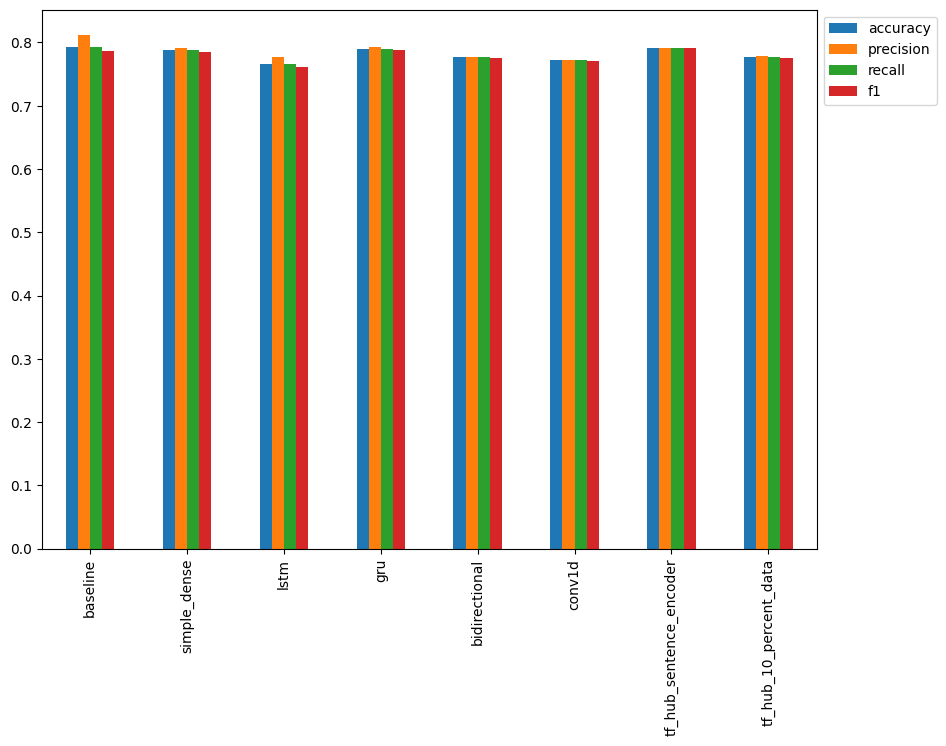

In [81]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<AxesSubplot:>

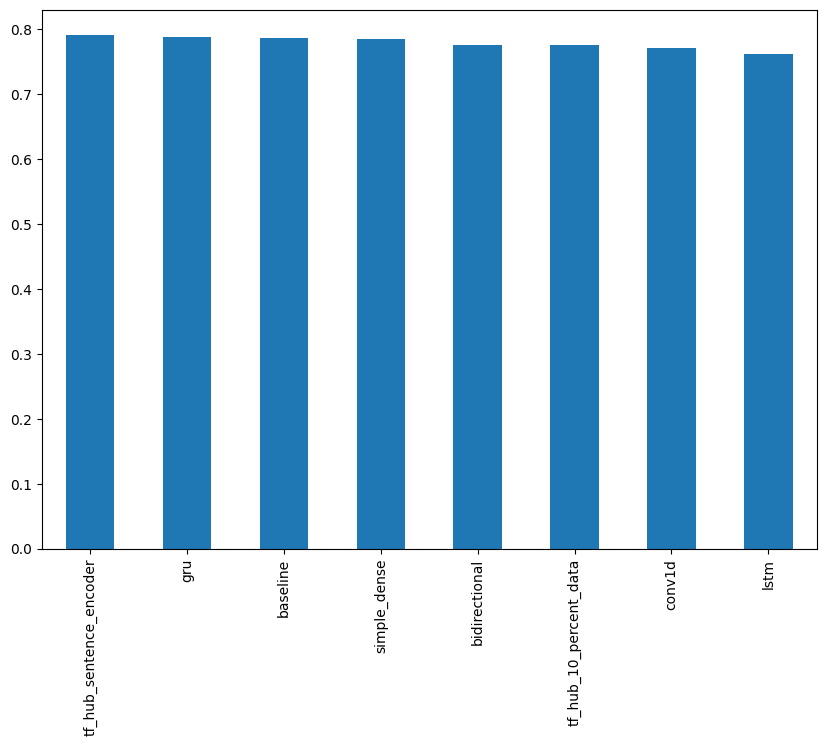

In [82]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

### Find the most wrong examples

* If our best model still isnt perfect, then what examples is it getting wrong?
* And of these wrong examples which ones is it getting most wrong

In [83]:
# Create DataFrame with validation sentences and best performing model predictions
if "08_model_6_USE_feature_extractor.zip" not in os.listdir("."):
    ! wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
    unzip_data("08_model_6_USE_feature_extractor.zip")

In [84]:
# IMport previously trained model
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")

In [85]:
model_6_pretrained.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4272 - accuracy: 0.8163


[0.427234411239624, 0.8162729740142822]

In [86]:
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_results = calculate_results(val_labels,model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

In [87]:
val_df = pd.DataFrame({"test": val_sentences,
                        "target":val_labels,
                        "prediction":model_6_pretrained_preds,
                        "pred_probs":tf.squeeze(model_6_pretrained_pred_probs)})
val_df

,test,target,prediction,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159811
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747274
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988756
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196263
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707678
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.137089
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.095921
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876961
760,Crack in the path where I wiped out this morni...,0,1.0,0.612693


In [88]:
# Find the wrong predictions and sort by prediction probability
most_wrong = val_df[val_df["target"]!=val_df["prediction"]].sort_values(by="pred_probs",ascending=False)

In [89]:
most_wrong.head(10)

,test,target,prediction,pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910273
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876961
628,@noah_anyname That's where the concentration c...,0,1.0,0.852338
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835610
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827305
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814792
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.811065
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803137
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766989
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766891


In [90]:
most_wrong.tail(10)

,test,target,prediction,pred_probs
536,@DavidVonderhaar At least you were sincere ??,1,0.0,0.067323
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.055051
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.054614
221,going to redo my nails and watch behind the sc...,1,0.0,0.054610
59,You can never escape me. Bullets don't harm me...,1,0.0,0.049626
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043936
233,I get to smoke my shit in peace,1,0.0,0.042156
38,Why are you deluged with low self-image? Take ...,1,0.0,0.039018
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038970
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037174


In [91]:
# Check the false poitives (predicted true but actually it is false)
for row in most_wrong[:5].itertuples():
    _, text,target,pred,pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f"Text :\n {text}\n")
    print("-------------------\n")

Target: 0, Pred: 1.0, Prob: 0.9102733731269836
Text :
 ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

-------------------

Target: 0, Pred: 1.0, Prob: 0.8769606947898865
Text :
 FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

-------------------

Target: 0, Pred: 1.0, Prob: 0.8523378968238831
Text :
 @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

-------------------

Target: 0, Pred: 1.0, Prob: 0.8356100916862488
Text :
 Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

-------------------

Target: 0, Pred: 1.0, Prob: 0.8273046612739563
Text :
 @AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

-------------------



In [92]:
# Check the false negatives (predicted false but actually it is true)
for row in most_wrong[-5:].itertuples():
    _, text,target,pred,pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f"Text :\n {text}\n")
    print("-------------------\n")

Target: 1, Pred: 0.0, Prob: 0.04393625259399414
Text :
 @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

-------------------

Target: 1, Pred: 0.0, Prob: 0.04215620085597038
Text :
 I get to smoke my shit in peace

-------------------

Target: 1, Pred: 0.0, Prob: 0.03901844844222069
Text :
 Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy

-------------------

Target: 1, Pred: 0.0, Prob: 0.038970060646533966
Text :
 Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP

-------------------

Target: 1, Pred: 0.0, Prob: 0.037174176424741745
Text :
 Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

-------------------



In [93]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


### Making predictions of test dataset

In [94]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences,5)
for x in test_samples:
    pred_probs = tf.squeeze(model_6_pretrained.predict([x]))
    pred = (tf.round(pred_probs))
    print(f"Pred: {int(pred)}, Prob: {pred_probs}")
    print(f"Text: \n{x}\n")
    print("--------------------------\n")

Pred: 0, Prob: 0.08326753228902817
Text: 
I ain't a crip or a blood....I'm doin my own thing

--------------------------

Pred: 0, Prob: 0.06047698110342026
Text: 
@m1tchell1987 YOU DESTROYED MEE OKAY? I THOUGHT YOU WERE DEAD! BUT I'M NOT AREN'T YOU GLAD THAT I'M NOT?

--------------------------

Pred: 0, Prob: 0.159936785697937
Text: 
Nuclear-Deal: Indo-Japan pact lies at the heart of two US reactor-based projects - The Indian Express 

Read more... http://t.co/FMxmNNRDFe

--------------------------

Pred: 0, Prob: 0.06009348854422569
Text: 
I think I might have a crush on my lover boy ?

--------------------------

Pred: 0, Prob: 0.09529966861009598
Text: 
@JagexSupport can u remove the email of the hijacker pls !! YKJL is my ign. i need to recover but pls block so they dont break bank pin!

--------------------------



## The speed/score tradeoff

In [95]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [105]:
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

In [108]:
# Create a function to measure time of prediction
import time
def pred_time(model,samples):
    start = time.perf_counter()
    model.predict(samples)
    stop = time.perf_counter()
    total_time = stop-start
    time_per_pred = total_time/len(samples)
    return total_time,time_per_pred

In [110]:
model_6_pretrained_time = pred_time(model_6_pretrained,val_sentences)
model_6_pretrained_time

(0.10364200995536521, 0.0001360131364243638)

In [111]:
baseline_time = pred_time(model_0,val_sentences)
baseline_time

(0.023346106987446547, 3.063793567906371e-05)

In [112]:
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

Text(0.5, 1.0, 'F1-Score versus time per prediction')

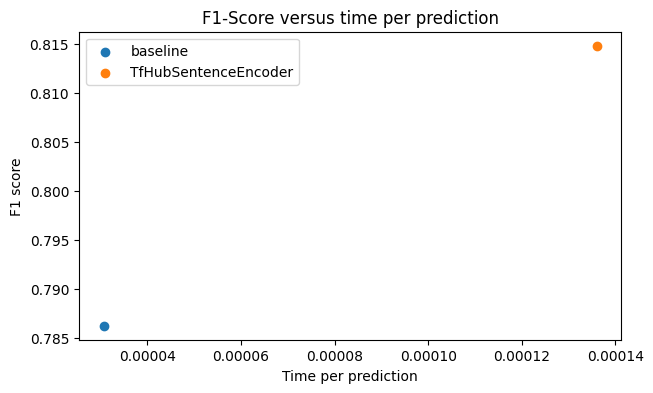

In [114]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.scatter(baseline_time[1],baseline_results["f1"],label="baseline")
plt.scatter(model_6_pretrained_time[1], model_6_pretrained_results["f1"],label="TfHubSentenceEncoder")
plt.legend()
plt.ylabel("F1 score")
plt.xlabel("Time per prediction")
plt.title("F1-Score versus time per prediction")

# Exercise

In [116]:
#Rebuild, compile and train model_1, model_2 and model_5 using the Keras Sequential API 
#instead of the Functional API.

: 